In [1]:
## Importer les packages
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import plotly.graph_objects as go

In [2]:
## Importer les données
## Les données sont mensuel et nous n'avons trouvé que 40 entreprises parmi 50 sur investing.com
import glob

chemin = r'french data/' 
all_files = glob.glob(chemin + '/*.csv') #glob.glob() pour collecter tous les csv fishiers en même temps
#print(all_files) #Vérifier l'ordre de fichier

lis = [] #créer une liste pour charger les fichiers

for fic in all_files:
    brut_data = pd.read_csv(fic) #lire les csv fichier un par un
    data = pd.DataFrame(brut_data, columns=["Price"]) #garder la seule colonne que nous allons utiliser, ici la colonne <Price>
    data["Price"] = data["Price"].astype(str).str.replace(",","")
    lis.append(data) #mettre les données dans la liste vide que nous avons créer avant

## Nommé chaque colonne par son code du bourse
## Initialement le nom des colonnes sont <Price>
for i in range(len(lis)):
    noms = ["LVMH", "HRMS", "AIRP", "OREP", "RENA", "SGOB", "ESLX", "DAST", "URW", "BNPP", "TEPRF", "ENGIE",
    "SASY", "SGEF", "TCFP", "SAF", "MICP", "AIR", "SCHN", "VIV", "PRTP", "MT", "CAGR", "VIE", "STM",
    "PERP", "ORAN", "PUBP", "EUFI", "CAPP", "TTEF", "AXAF", "CARR", "LEGD", "DANO", "SOGN", "STLA", "WLN", "ALSO",
    "BOUY"] #Nous mettons les codes en ordre correcte avec le code print(all_files)
    lis[i].rename(columns = {"Price": noms[i]}, inplace = True) #renommer chaque colonne

## Maintenant les listes de données sont séparate dans une grande liste, nous allons fusionner les liste en un dataframe
stockDf = pd.concat(lis, axis = 1) #pd.concat pour fusionner les liste en un dataframe
stockDf = stockDf.sort_index(ascending = False) #Il faut inverser la date de donnée sinon les rendements logarithmes ne pas correct 
#print(stockDf)

In [3]:
## Premièrement, nous allons calculer les taux de rendements de chaque actif mensuellement
## Deuxième étape, nous calculons ses moyennes et ses matrice de covariance
## D'après cette fonction, nous allons avoir la fonction x_tranpose%*%sigma%*%x pour optimiser
def getData(stockDf):
    stockvar = stockDf.apply(pd.to_numeric) #transmettre les données de dataframe en numérique
    taux_rendement = stockvar.pct_change().apply(lambda x: np.log(1 + x)) #taux de rendement r_t = (P_t-P_t-1)/(P_t-1)
    taux_rendement = taux_rendement.iloc[1: , :]
    moyennes = taux_rendement.mean() #l'espérance de rendement
    matriceCov = taux_rendement.cov() #Sigma
    return taux_rendement, moyennes, matriceCov, stockvar

taux_rendement, moyennesAct, matriceCov, stockvar = getData(stockDf)
#print("moyennes :\n", moyennesAct, "matrice de covariance :\n", matriceCov)

<Axes: ylabel='Frequency'>

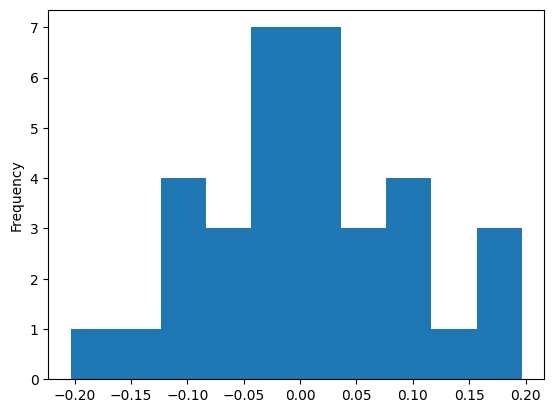

In [4]:
## Affiche le graphe de distribution log-normale
## Nous choisissons un actif par hasard
taux_rendement["SAF"].plot(kind = "hist") # Car nous avons utilisé rendements logarithmes

In [5]:
## Table 1
## Constuite des tableaus pour visualiser les rendements
from tabulate import tabulate

AscenMoys = round(moyennesAct.nlargest(10)*100, 2)
DescenMoys = round(moyennesAct.nsmallest(10)*100, 2)
AscenMoys = AscenMoys.to_frame()
DescenMoys = DescenMoys.to_frame()

col_names =["Actif", "Rendement (%)"]
print("Les 10 premier rendements :\n")
print(tabulate(AscenMoys, headers = col_names, tablefmt = "pretty"))

print("\nLes 10 derniers rendements :\n")
print(tabulate(DescenMoys, headers = col_names, tablefmt = "pretty"))

Les 10 premier rendements :

+-------+---------------+
| Actif | Rendement (%) |
+-------+---------------+
| CARR  |     2.42      |
| ENGIE |     1.94      |
| OREP  |     1.83      |
| ORAN  |     1.44      |
| TCFP  |     1.26      |
|  VIE  |     1.24      |
|  AIR  |     1.21      |
| AIRP  |     1.04      |
|  URW  |     1.01      |
|  SAF  |     0.92      |
+-------+---------------+

Les 10 derniers rendements :

+-------+---------------+
| Actif | Rendement (%) |
+-------+---------------+
| EUFI  |     -2.6      |
| RENA  |     -1.71     |
| DANO  |     -1.08     |
|  VIV  |     -1.03     |
| AXAF  |     -0.8      |
| ALSO  |     -0.71     |
|  MT   |     -0.64     |
| SGEF  |     -0.59     |
|  STM  |     -0.58     |
| SGOB  |     -0.56     |
+-------+---------------+


In [6]:
## Cette fonction nous permets de savoir la volatilité de chaque actif hebdomadaire
def EcartType_Act(taux_rendement):
    "ecart_type = np.sqrt(np.sum((taux_rendement-moyennes)**2)/47)"
    ecart_type = taux_rendement.std()
    return ecart_type

ecart_typeAct = EcartType_Act(taux_rendement)
#print(ecart_typeAct)

In [7]:
## Table 2
## Constuite des tableau pour visualiser les volatilités
AscenRis = round(ecart_typeAct.nlargest(10)*100, 2)
DescenRis = round(ecart_typeAct.nsmallest(10)*100, 2)
AscenRis = AscenRis.to_frame()
DescenRis = DescenRis.to_frame()

col_names =["Actif", "Ecart-type (%)"]
print("Les 10 premiers ecart-types :\n")
print(tabulate(AscenRis, headers=col_names, tablefmt = "pretty"))

print("\nLes 10 derniers ecart-types :\n")
print(tabulate(DescenRis, headers = col_names, tablefmt = "pretty"))

Les 10 premiers ecart-types :

+-------+----------------+
| Actif | Ecart-type (%) |
+-------+----------------+
| EUFI  |      19.0      |
|  STM  |     15.11      |
| SGEF  |     14.83      |
| HRMS  |     14.76      |
| ENGIE |     14.53      |
| SOGN  |     13.32      |
| ALSO  |     13.31      |
|  MT   |     12.18      |
|  AIR  |     11.77      |
| RENA  |     11.75      |
+-------+----------------+

Les 10 derniers ecart-types :

+-------+----------------+
| Actif | Ecart-type (%) |
+-------+----------------+
| AXAF  |      5.56      |
| PUBP  |      5.78      |
| STLA  |      5.97      |
|  WLN  |      6.13      |
|  URW  |      6.16      |
| LVMH  |      6.22      |
| DANO  |      6.28      |
| OREP  |      6.83      |
| MICP  |      7.48      |
| ESLX  |      7.62      |
+-------+----------------+


In [8]:
## Pondération du capital pour chaque actif qui la somme est égale à 1
def ponderation(n):
    k = [np.random.uniform(0, 1) for i in range(n)]
    lis_pond = []
    for i in range(len(k)):
        lis_pond.append(k[i]/sum(k))
    return lis_pond

In [9]:
## Portefeuille aléatoire
def portefeuille(rendements):
    p_moy = np.asmatrix(np.mean(rendements, axis = 1)) #matrice de moyenne de chaque ligne
    xpond = ponderation(rendements.shape[0]) #shape : dimension de matrice, ici [0]
                                                 #est la quantité de ligne de matrice
    x = np.asmatrix(xpond)
    c = np.asmatrix(np.cov(rendements)) #matrice de covariance

    R = x*p_moy.T #l'espérance de rendement
    V = np.sqrt(x*c*x.T) #le risque

    sharpeRatio = R/V

    if V>2:
        return portefeuille(rendements)
    return R, V, sharpeRatio, [xpond]

#print(portefeuille(taux_rendement.T))

In [29]:
## Échantillon du portefeuille
n_portefeuilles = 1500
#constuite des colonne, ici nous aurons 4 colonnes
# R_esp, risq, SR, xpond = np.column_stack([ 
#     portefeuille(taux_rendement.T)  
#     for i in range(n_portefeuilles) ])

R_esp, risq, SR, xpond = zip(*[portefeuille(taux_rendement.T) for i in range(n_portefeuilles)])


R_esp, risq, SR, xpond = np.array(R_esp).flatten(), np.array(risq).flatten(), np.array(SR).flatten(), np.array(xpond)


In [30]:
## Afficher le graphe d'échantillon de portefeuille
import plotly.graph_objects as go

Portefeuilles = go.Scatter(x = risq,y = R_esp,mode = "markers", marker = dict(size=12,
        color = SR, colorscale = "Viridis", showscale = True,line_width = 1,colorbar = dict(title = "Sharpe<br>Ratio")
        ),text = "portefeuille")

data = [Portefeuilles]

layout = go.Layout(title = "Echantillon de portefeuille", yaxis = dict(title = "Rendement"), xaxis = dict(title = "Volatilité"),
                    width = 800, height = 600, showlegend = False)

fig = go.Figure(data = data, layout = layout)

fig.show()

In [31]:
## Chercher le minimum de la volatilité dans la graphe
minIndex = risq.argmin()
#print(xpond[minIndex])

In [32]:
## Visualiser le point de volatilité minimum sur l'échantillon de portefeuille : Le point noir
Portefeuilles = go.Scatter(x = risq,y = R_esp,mode = "markers", marker = dict(size=12,
        color = SR, colorscale = "Viridis", showscale = True,line_width = 1,colorbar = dict(title = "Sharpe<br>Ratio")
        ),text = "portefeuille")

Minimum_Volatilite = go.Scatter(x = np.array(risq[minIndex]), y = np.array(R_esp[minIndex]),mode = "markers",
                                marker = dict(color = "black",size = 12,line_width = 1),text = "Volatilité minimum" )

data = [Portefeuilles, Minimum_Volatilite]

layout = go.Layout(title = "Echantillon de portefeuille", yaxis = dict(title = "Rendement"), xaxis = dict(title = "Volatilité"),
                    width = 800, height = 600, showlegend = False)
                    
fig = go.Figure(data = data, layout = layout)

fig.show()

In [33]:
## Cherher le maximum de Sharpe Ratio
maxIndex = SR.argmax()
#print(SR[maxIndex])
#print(xpond[maxIndex])

In [34]:
## Visualiser le point du Sharpe Ratio maximum sur l'échantillon de portefeuille : Le point rouge
Portefeuilles = go.Scatter(x = risq,y = R_esp, mode = "markers", marker = dict(size=12,
        color = SR, colorscale = "Viridis", showscale = True,line_width = 1,colorbar = dict(title = "Sharpe<br>Ratio")
        ),text = "portefeuille")

Minimum_Volatilite = go.Scatter(x = np.array(risq[minIndex]), y = np.array(R_esp[minIndex]), mode = "markers",
                                marker = dict(color = "black", size = 12, line_width = 1),text = "Risque minimum" )

Maximum_SharpeRatio = go.Scatter(x = np.array(risq[maxIndex]), y = np.array(R_esp[maxIndex]), mode = "markers",
                                marker = dict(color = "red", size=12, line_width = 1),text = "Maximal Sharpe Ratio" )

data = [Portefeuilles, Minimum_Volatilite, Maximum_SharpeRatio]

layout = go.Layout(title = "Echantillon de portefeuille", yaxis = dict(title = "Rendement"), xaxis = dict(title = "Volatilité"),
                    width = 800, height = 600, showlegend = False)
                    
fig = go.Figure(data = data, layout = layout)

fig.show()

In [35]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

## Calculer le rendement maximum de portefeuille
## Même l'algorithme <SciPy>, Même façon que calculer le Sharpe Ratio maximum
def OptPortefeuille(w):
    p_moy = np.mean(taux_rendement.T, axis = 1)
    Sigma = np.cov(taux_rendement.T)
    w = np.array(w)
    R = np.sum(p_moy*w)
    V = np.sqrt(np.dot(w, np.dot(Sigma, w)))
    return -R, V

## cette fonction permet de renvoyer que la valeur de rendement
def ETPortefeuilleV(taux):
   return OptPortefeuille(taux)[1]

def ETPortefeuilleR(taux):
   return OptPortefeuille(taux)[0]

def minimiserVol(taux):
    "Maximiser le rendement du portefeuille, en modifiant les pondérations d'actif du portefeuille"
    w0 = len(taux)*[1./len(taux)] #supposition initiale
    constraintes = ({"type": "eq", "fun": lambda x: np.sum(x) - 1}) #somme de x = 1
    bornes = Bounds([0], [1.0]) #0<=x<=1
    resu = minimize(ETPortefeuilleV, w0, method = "SLSQP", bounds = bornes,
                        constraints = constraintes)
    return resu

def MaximerR(taux):
    "Maximiser le rendement du portefeuille, en modifiant les pondérations d'actif du portefeuille"
    w0 = len(taux)*[1./len(taux)] #supposition initiale
    constraintes = ({"type": "eq", "fun": lambda x: np.sum(x) - 1}) #somme de x = 1
    bornes = Bounds([0], [1.0]) #0<=x<=1
    resu = minimize(ETPortefeuilleR, w0, method = "SLSQP", bounds = bornes,
                        constraints = constraintes)
    return resu

In [36]:
Min_Vol = minimiserVol(taux_rendement.T) 
MinVolPond = Min_Vol["x"] 
p_moy=np.mean(taux_rendement.T, axis=1) 
#print("Pondération de portefeuille avec risque minimum", MinVolPond)

MinVolRend = np.sum(p_moy*MinVolPond)
#print("Rendement de portefeuille avec risque minimum :", MinVolRend)
MinVolRisk = np.sqrt(np.sum(np.dot(MinVolPond.T, np.dot(np.cov(taux_rendement.T), MinVolPond)))) 
#print("Volatolité de portefeuille avec risque minimum :", MinVolRisk)
Min_SR = MinVolRend/MinVolRisk
#print("Le Sharpe Ratio portefeuille avec risque minimum :", Min_SR)

In [39]:
## Table 3
## Constuite des tableau pour visualiser les données de portefeuille avec risque minimum 
noms = ["LVMH", "HRMS", "AIRP", "OREP", "RENA", "SGOB", "ESLX", "DAST", "URW", "BNPP", "TEPRF", "ENGIE",
    "SASY", "SGEF", "TCFP", "SAF", "MICP", "AIR", "SCHN", "VIV", "PRTP", "MT", "CAGR", "VIE", "STM",
    "PERP", "ORAN", "PUBP", "EUFI", "CAPP", "TTEF", "AXAF", "CARR", "LEGD", "DANO", "SOGN", "STLA", "WLN", "ALSO",
    "BOUY"]

df_MinVolPond = pd.DataFrame(MinVolPond)
df_MinVolPond = df_MinVolPond.set_index([pd.Index( code for code in noms)])
df = [round(moyennesAct*100, 2), round(ecart_typeAct*100, 2), round(df_MinVolPond*100, 4)]


conclu_MinVol = pd.concat(df, axis = 1)
conclu_MinVol.columns = ["Moyennes (%)", "Ecart-type (%)", "Pondération (%)"]
print(conclu_MinVol)
print("Le Sharpe Ratio de portefeuille avec risque minimum :", Min_SR)
print("Rendement de portefeuille avec risque minimum :", round(MinVolRend*100, 4), "%\n", "Volatilité de portefeuille avec risque minimum :", round(MinVolRisk*100, 4), "%")

Moy_EcartType = pd.Series(round(pd.Series(ecart_typeAct)*100, 2).mean())
Std_EcartType = pd.Series(round(pd.Series(ecart_typeAct)*100, 2).std())
print("Moyennes de volatilité des actif : ", Moy_EcartType, "%")
print("Ecart-type de volatilité des actif : ", Std_EcartType, "%")

       Moyennes (%)  Ecart-type (%)  Pondération (%)
LVMH           0.21            6.22          12.9317
HRMS          -0.04           14.76           0.0000
AIRP           1.04           10.03           0.0000
OREP           1.83            6.83           0.0000
RENA          -1.71           11.75           0.0000
SGOB          -0.56            8.22           0.0000
ESLX           0.05            7.62           0.0000
DAST          -0.20           10.92           0.0000
URW            1.01            6.16           7.2213
BNPP           0.82            8.21           0.0000
TEPRF          0.72           11.43           0.0000
ENGIE          1.94           14.53           0.0000
SASY           0.06            8.69           0.0000
SGEF          -0.59           14.83           0.0000
TCFP           1.26            7.90           0.0000
SAF            0.92            9.43           3.9582
MICP          -0.52            7.48           0.0000
AIR            1.21           11.77           

In [40]:
## Visualiser le point de portefeuille avec risque minimum sur l'échantillon de portefeuille : Le point orange
Portefeuilles = go.Scatter(x = risq, y = R_esp, mode = "markers", marker = dict(size = 12,
        color = SR, colorscale = "Viridis", showscale = True, line_width = 1, colorbar = dict(title = "Sharpe<br>Ratio")
        ),text = "portefeuille")
Minimum_Volatilite = go.Scatter(x = np.array(risq[minIndex]), y = np.array(R_esp[minIndex]), mode = "markers",
                                marker = dict(color = "black", size = 12, line_width = 1), text = "Risque minimum" )

Maximum_SharpeRatio = go.Scatter(x = np.array(risq[maxIndex]), y = np.array(R_esp[maxIndex]), mode = "markers",
                                marker = dict(color = "red", size = 12, line_width = 1), text = "Maximal Sharpe Ratio" )

MinVol_Portefeuille = go.Scatter(x = np.array(MinVolRisk), y = np.array(MinVolRend), mode = "markers",
                                marker = dict(color = "orange", size = 12, line_width = 1), text = "Le Portefeuille avec risque minimum" )
                                
data = [Portefeuilles, Minimum_Volatilite, Maximum_SharpeRatio, MinVol_Portefeuille]

layout = go.Layout(title = "Echantillon de portefeuille", yaxis = dict(title = "Rendement"), xaxis = dict(title = "Volatilité"),
                    width = 800, height = 600, showlegend = False)
fig = go.Figure(data = data, layout = layout)

fig.show()

In [41]:
Max_Ren = MaximerR(taux_rendement.T) 
MaxRenPond = Max_Ren["x"] 
p_moy=np.mean(taux_rendement.T, axis=1) 
#print("Pondération de portefeuille avec risque minimum", MaxRenPond)

MaxRenRend = np.sum(p_moy*MaxRenPond)
#print("Rendement de portefeuille avec risque minimum :", MaxRenRend)
MaxRenRisk = np.sqrt(np.sum(np.dot(MaxRenPond.T, np.dot(np.cov(taux_rendement.T), MaxRenPond)))) 
#print("Volatolité de portefeuille avec risque minimum :", MaxRenRisk)
Max_SR = MaxRenRend/MaxRenRisk
#print("Le Sharpe Ratio portefeuille avec risque minimum :", Max_SR)

In [43]:
## Table 4
## Constuite des tableau pour visualiser les données de portefeuille avec rendement maximale  
noms = ["LVMH", "HRMS", "AIRP", "OREP", "RENA", "SGOB", "ESLX", "DAST", "URW", "BNPP", "TEPRF", "ENGIE",
    "SASY", "SGEF", "TCFP", "SAF", "MICP", "AIR", "SCHN", "VIV", "PRTP", "MT", "CAGR", "VIE", "STM",
    "PERP", "ORAN", "PUBP", "EUFI", "CAPP", "TTEF", "AXAF", "CARR", "LEGD", "DANO", "SOGN", "STLA", "WLN", "ALSO",
    "BOUY"]

df_MaxRenPond = pd.DataFrame(MaxRenPond)
df_MaxRenPond = df_MaxRenPond.set_index([pd.Index( code for code in noms)])
df = [round(moyennesAct*100, 2), round(ecart_typeAct*100, 2), round(df_MaxRenPond*100, 4)]

conclu_MaxRen = pd.concat(df, axis = 1)
conclu_MaxRen.columns = ["Moyennes (%)", "Ecart-type (%)", "Pondération (%)"]
print(conclu_MaxRen)
print("Le Sharpe Ratio de portefeuille avec rendement maximum:", Max_SR)
print("Rendement de portefeuille avec rendement maximum :", round(MaxRenRend*100, 4), "%\n", "Ecart-type de portefeuille avec rendement maximum :", round(MaxRenRisk*100, 4), "%")

Moy_EcartType = pd.Series(round(ecart_typeAct*100, 2).mean())
Std_EcartType = pd.Series(round(ecart_typeAct*100, 2).std())
print("Moyennes de volatilité des actif : ", Moy_EcartType, "%")
print("Ecart-type de volatilité des actif : ", Std_EcartType, "%")

       Moyennes (%)  Ecart-type (%)  Pondération (%)
LVMH           0.21            6.22              0.0
HRMS          -0.04           14.76              0.0
AIRP           1.04           10.03              0.0
OREP           1.83            6.83              0.0
RENA          -1.71           11.75              0.0
SGOB          -0.56            8.22              0.0
ESLX           0.05            7.62              0.0
DAST          -0.20           10.92              0.0
URW            1.01            6.16              0.0
BNPP           0.82            8.21              0.0
TEPRF          0.72           11.43              0.0
ENGIE          1.94           14.53              0.0
SASY           0.06            8.69              0.0
SGEF          -0.59           14.83              0.0
TCFP           1.26            7.90              0.0
SAF            0.92            9.43              0.0
MICP          -0.52            7.48              0.0
AIR            1.21           11.77           

In [44]:
## Visualiser le point de portefeuille avec risque minimum sur l'échantillon de portefeuille : Le point orange
Portefeuilles = go.Scatter(x = risq, y = R_esp, mode = "markers", marker = dict(size = 12,
        color = SR, colorscale = "Viridis", showscale = True, line_width = 1, colorbar = dict(title = "Sharpe<br>Ratio")
        ),text = "portefeuille")
Minimum_Volatilite = go.Scatter(x = np.array(risq[minIndex]), y = np.array(R_esp[minIndex]), mode = "markers",
                                marker = dict(color = "black", size = 12, line_width = 1), text = "Risque minimum" )

Maximum_SharpeRatio = go.Scatter(x = np.array(risq[maxIndex]), y = np.array(R_esp[maxIndex]), mode = "markers",
                                marker = dict(color = "red", size = 12, line_width = 1), text = "Maximal Sharpe Ratio" )

MaxRen_Portefeuille = go.Scatter(x = np.array(MaxRenRisk), y = np.array(MaxRenRend), mode = "markers",
                                marker = dict(color = "green", size = 12, line_width = 1), text = "Le Portefeuille avec rendement maximum" )
                                
data = [Portefeuilles, Minimum_Volatilite, Maximum_SharpeRatio, MaxRen_Portefeuille]

layout = go.Layout(title = "Echantillon de portefeuille", yaxis = dict(title = "Rendement"), xaxis = dict(title = "Volatilité"),
                    width = 800, height = 600, showlegend = False)
fig = go.Figure(data = data, layout = layout)

fig.show()

In [45]:
def ngSR(w = ponderation(taux_rendement.T.shape[0])):
    "Pour maximiser l'espérance de rendement de portefeuille, il faut que maximiser le Sharpe Ratio"
    "Pour maximiser le Sharpe Ratio, il faut que nous minimiser le nagetive de Sharpe Ratio"
    "parce que SciPy ne propose pas l'algorithme de maximiser"
    p_moy = np.mean(taux_rendement.T, axis = 1)
    Sigma = np.cov(taux_rendement.T)
    w = np.array(w)
    R = np.sum(p_moy*w)
    V = np.sqrt(np.dot(w, np.dot(Sigma, w)))
    SR = R/V
    return -1*SR

def optimisation():
    "Maximiser l'espérance de rendement de portefeuille, en modifiant les pondérations d'actif du portefeuille"
    w0 = len(taux_rendement.T)*[1./len(taux_rendement.T)]
    bornes = Bounds([0], [1.])
    constraintes = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    res = minimize(ngSR, w0, method = "SLSQP", bounds = bornes, constraints = constraintes)
    return res

In [46]:
Res_Opti = optimisation()
OptimumPond = Res_Opti["x"] 
p_moy = np.mean(taux_rendement.T, axis = 1) 
#print("Pondération de portefeuille optimum :",OptimumPond)

OptimumRend = np.sum(p_moy*OptimumPond)
#print("Rendement de portefeuille optimum :", OptimumRend)
OptimumRisk = np.sqrt(np.sum(np.dot(OptimumPond.T, np.dot(np.cov(taux_rendement.T), OptimumPond))))
#print("Volatolité de portefeuille optimum :", OptimumRisk)
Optimum_SR = OptimumRend/OptimumRisk
#print("Le Sharpe Ratio de portefeuille optimum :", Optimum_SR)


In [48]:
## Table 5
## Constuite des tableau pour visualiser les données de portefeuille optimum 
noms = ["LVMH", "HRMS", "AIRP", "OREP", "RENA", "SGOB", "ESLX", "DAST", "URW", "BNPP", "TEPRF", "ENGIE",
    "SASY", "SGEF", "TCFP", "SAF", "MICP", "AIR", "SCHN", "VIV", "PRTP", "MT", "CAGR", "VIE", "STM",
    "PERP", "ORAN", "PUBP", "EUFI", "CAPP", "TTEF", "AXAF", "CARR", "LEGD", "DANO", "SOGN", "STLA", "WLN", "ALSO",
    "BOUY"]

df_OptimumPond = pd.DataFrame(OptimumPond)
df_OptimumPond = df_OptimumPond.set_index([pd.Index( code for code in noms)])
df = [round(moyennesAct*100, 2), round(ecart_typeAct*100, 2), round(df_OptimumPond*100, 4)]

conclu = pd.concat(df, axis = 1)
conclu.columns =["Moyennes (%)", "Ecart-type (%)", "Pondération (%)"]
print(conclu)
print("Le Sharpe Ratio du portefeuille optimum :", Optimum_SR)
print("Rendement du portefeuille optimum :", round(OptimumRend*100, 4), "%\n", "Ecart-type de portefeuille optimum :", round(OptimumRisk*100, 4), "%")

Moy_EcartType = pd.Series(round(ecart_typeAct*100,2).mean())
Std_EcartType = pd.Series(round(ecart_typeAct*100,2).std())
print("Moyennes du volatilité des actifs : ",Moy_EcartType,"%")
print("Ecart-type du volatilité des actifs : ", Std_EcartType,"%")


       Moyennes (%)  Ecart-type (%)  Pondération (%)
LVMH           0.21            6.22           0.0000
HRMS          -0.04           14.76           0.0000
AIRP           1.04           10.03           0.0000
OREP           1.83            6.83          29.1199
RENA          -1.71           11.75           0.0000
SGOB          -0.56            8.22           0.0000
ESLX           0.05            7.62           0.0000
DAST          -0.20           10.92           0.0000
URW            1.01            6.16           0.0000
BNPP           0.82            8.21           0.0000
TEPRF          0.72           11.43           0.0000
ENGIE          1.94           14.53           0.9741
SASY           0.06            8.69           0.0000
SGEF          -0.59           14.83           0.0000
TCFP           1.26            7.90           0.0000
SAF            0.92            9.43           0.0000
MICP          -0.52            7.48           0.0000
AIR            1.21           11.77           

In [49]:
## Le point orange en haut
Portefeuilles = go.Scatter(x = risq, y = R_esp, mode = "markers", marker = dict(size=12,
        color = SR, colorscale = "Viridis", showscale = True, line_width = 1, colorbar = dict(title = "Sharpe<br>Ratio")
        ), text = "portefeuille")

Minimum_Volatilite = go.Scatter(x = np.array(risq[minIndex]), y = np.array(R_esp[minIndex]), mode = "markers",
                                marker = dict(color = "black", size=12, line_width = 1), text = "Risque minimum" )

Maximum_SharpeRatio = go.Scatter(x = np.array(risq[maxIndex]), y = np.array(R_esp[maxIndex]), mode = "markers",
                                marker = dict(color = "red", size = 12, line_width = 1), text = "Maximal Sharpe Ratio" )

MinVol_Portefeuille = go.Scatter(x = np.array(MinVolRisk), y = np.array(MinVolRend), mode = "markers",
                                marker = dict(color = "orange", size = 12, line_width = 1), text = "Le minimum volatilitéPortefeuille" )

Optimum_Portefeuille = go.Scatter(x = np.array(OptimumRisk), y = np.array(OptimumRend), mode = "markers",
                                marker = dict(color = "orange", size = 12, line_width = 1), text = "L'optimum Portefeuille" )
                                
data = [Portefeuilles, Minimum_Volatilite, Maximum_SharpeRatio, MinVol_Portefeuille, Optimum_Portefeuille]

layout = go.Layout(title = "Echantillon de portefeuille", yaxis = dict(title = "Rendement"), xaxis = dict(title = "Volatilité"),
                    width = 800, height = 600, showlegend = False)

fig = go.Figure(data = data, layout = layout)

fig.show()

In [50]:
def EffPortefeuille(ponderations, taux):
    p_moy = np.mean(taux, axis = 1)
    Sigma = np.cov(taux)
    rendements = np.sum(p_moy*ponderations) #le rendement de portefeuille avec différent pondération en chaque actif
    ecart_type = np.sqrt(np.dot(ponderations.T, np.dot(Sigma, ponderations))) #le risque du portefeuille
    return rendements, ecart_type


In [51]:
## cette fonction permet de renvoyer que la valeur de rendements
def rendePortefeuille(x, taux):
    return EffPortefeuille(x, taux)[0] 

def efficientOpt(taux, rendeCible):
    """pour chaque rendement cible, nous voulons optimiser le portefeuille pour une variance minimale"""
    w0 = len(taux)*[1./len(taux)]
    constraintes = ({"type": "eq", "fun": lambda x: rendePortefeuille(x, taux) - rendeCible},
                        {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bornes = Bounds([0], [1.0]) #0<=x<=1
    effOpt = minimize(ETPortefeuilleV, w0, method = "SLSQP", bounds = bornes,
                            constraints = constraintes)
    return effOpt

In [52]:
def CalRes(taux):
    efficientlis = []
    rendeCible = np.linspace(MinVolRend, OptimumRend, 20)
    for cible in rendeCible:
        efficientlis.append(efficientOpt(taux, cible)["fun"])

    return efficientlis, rendeCible

#efficientlis, rendeCible = CalRes(taux_rendement.T)
#print(rendeCible)

In [53]:
def EF_graphe(taux):
    "Afficher un graphe présentent le minimum volatilité, maximum sharpe ratio etefficient frontier"
    efficientlis, rendeCible = CalRes(taux)

    Portefeuilles = go.Scatter(x = risq, y = R_esp, mode = "markers", marker = dict(size=12,
        color = SR, colorscale = "Viridis", showscale = True, line_width = 1, colorbar = dict(title = "Sharpe<br>Ratio")
        ), text = "portefeuille", showlegend = False)

    Minimum_Volatilite = go.Scatter(x = np.array(risq[minIndex]), y = np.array(R_esp[minIndex]), mode = "markers",
                                marker = dict(color = "black", size=12, line_width = 1), text = "Risque minimum", showlegend = False )

    Maximum_SharpeRatio = go.Scatter(x = np.array(risq[maxIndex]), y = np.array(R_esp[maxIndex]), mode = "markers",
                                marker = dict(color = "red", size = 12, line_width = 1), text = "Maximal Sharpe Ratio", showlegend = False )

    MinVol_Portefeuille = go.Scatter(x = np.array(MinVolRisk), y = np.array(MinVolRend), mode = "markers",
                                marker = dict(color = "orange", size = 12, line_width = 1), text = "Le minimum volatilitéPortefeuille", showlegend = False )

    Optimum_Portefeuille = go.Scatter(x = np.array(OptimumRisk), y = np.array(OptimumRend), mode = "markers",
                                marker = dict(color = "orange", size = 12, line_width = 1), text = "L'optimum Portefeuille", showlegend = False )
    
    EF_courbe = go.Scatter(x = [ef_ecty for ef_ecty in efficientlis], y = [cible for cible in rendeCible], mode = "lines+markers",
                            marker = dict(symbol = "arrow", color = "black"), name = "Efficient Frontière")

    MaxRen_Portefeuille = go.Scatter(x = np.array(MaxRenRisk), y = np.array(MaxRenRend), mode = "markers",
                                marker = dict(color = "green", size = 12, line_width = 1), text = "Le Portefeuille avec rendement maximum", showlegend = False )
    
    data = [Portefeuilles, Minimum_Volatilite, Maximum_SharpeRatio, Optimum_Portefeuille, MinVol_Portefeuille, EF_courbe, MaxRen_Portefeuille]                       

    layout = go.Layout(
        title = "Echantillon de portefeuille", yaxis = dict(title = "Rendement"), xaxis = dict(title = "Volatilité"),
        showlegend = True, legend = dict(x = 0.75, y = 0, traceorder = "normal", bgcolor = "#E2E2E2", 
        bordercolor = "black", borderwidth = 2), width = 800, height = 600
    )

    fig = go.Figure(data = data, layout = layout)
    return fig.show()

EF_graphe(taux_rendement.T)